# Pre processing the data

## Reading the data and setting imports


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Baixar recursos necessários
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


df_raw = pd.read_csv('../data/raw/full_data_2021_FORD.csv')
df_raw.head(1)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dighz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Year,Make,Model,odiNumber,manufacturer,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,vin,components,summary,products
0,2021,FORD,F-350 REGULAR CAB,11639053,Ford Motor Company,False,False,0,0,12/31/2024,01/28/2025,1FT8W3BT2ME,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,"[{'type': 'Vehicle', 'productYear': '2021', 'p..."


## Initial steps to process the data

In [3]:
# Removing unnecessary columns
df_final = df_raw.drop(['Make','odiNumber', 'manufacturer', 'vin', 'products'], axis=1)

In [4]:
# Changing the type of bool to int

df_final['fire'] = df_final['fire'].astype(int)
df_final['crash'] = df_final['crash'].astype(int)

In [5]:
# Converting the 'dateOfIncident' and 'dateComplaintFiled' columns to datetime format
df_final['dateOfIncident'] = pd.to_datetime(df_final['dateOfIncident'])
df_final['dateComplaintFiled'] = pd.to_datetime(df_final['dateComplaintFiled'])

# Creating a new feature that could be valuable for the model: the difference in days between the incident date and the complaint filed date
df_final['daysBetween'] = (df_final['dateComplaintFiled'] - df_final['dateOfIncident']).dt.days


In [6]:
# Splitting the 'components' column into a list of components for each row, handling missing values
df_final["components_list"] = df_final["components"].apply(lambda x: x.split(",") if pd.notna(x) else [])


In [7]:
# Text preprocessing function

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    
    text = text.lower()
    
    # Tokenization: Split the text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords (common words like 'the', 'and', etc.)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatization: Convert words to their base or root form (e.g., 'running' to 'run')
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)  

df_final['processed_summary'] = df_final['summary'].apply(preprocess_text)

In these case i decided to use bert because its a more robust model that generates contextual embeddings.
This is important for analyzing complaints, as it helps capture the full meaning of the text and identify patterns or issues more accurately

In [42]:
from transformers import BertTokenizer, BertModel
import torch


# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_model_embedding(text):
    """Converts text into a BERT embedding"""
    if pd.isna(text):
        return torch.zeros(768)  
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df_final['summary_embedding'] = df_final['summary'].apply(get_model_embedding)
df_final['model_embedding'] = df_final['Model'].apply(get_model_embedding)


In [8]:
# Calculating the word count and character count for the processed summary
df_final["word_count"] = df_final["processed_summary"].apply(lambda x: len(x.split()))  # Count the number of words
df_final["char_count"] = df_final["processed_summary"].apply(len)  # Count the number of characters

In [9]:
from textblob import TextBlob

# Calculating the sentiment polarity for each processed summary
df_final['sentiment'] = df_final['processed_summary'].apply(lambda x: TextBlob(x).sentiment.polarity)

# 1.0 → Positive, 0.0 → Neutral, -1.0 → Negative

In [10]:
# Analyzing the distribution of data in the 'components
df_final['components_list'].explode().value_counts()

components_list
POWER TRAIN                           3605
ELECTRICAL SYSTEM                     2081
UNKNOWN OR OTHER                      1534
ENGINE                                1418
SERVICE BRAKES                        1301
VISIBILITY                            1107
STRUCTURE                              907
VISIBILITY/WIPER                       759
FORWARD COLLISION AVOIDANCE            676
WHEELS                                 589
EXTERIOR LIGHTING                      524
SUSPENSION                             431
STEERING                               429
FUEL/PROPULSION SYSTEM                 419
BACK OVER PREVENTION                   408
VEHICLE SPEED CONTROL                  343
ENGINE AND ENGINE COOLING              316
LANE DEPARTURE                         216
 HYDRAULIC                             206
EQUIPMENT                              206
FUEL SYSTEM                            153
LATCHES/LOCKS/LINKAGES                 147
SEAT BELTS                            

In [11]:
# Categorias de problemas
category_map = {
    'ENGINE': 'Engine and Performance',
    'POWER TRAIN': 'Engine and Performance',
    'FUEL SYSTEM': 'Engine and Performance',
    'ENGINE AND ENGINE COOLING': 'Engine and Performance',
    'HYBRID PROPULSION SYSTEM': 'Engine and Performance',
    
    'AIR BAGS': 'Safety and Brakes',
    'SEAT BELTS': 'Safety and Brakes',
    'SERVICE BRAKES': 'Safety and Brakes',
    'LATCHES/LOCKS/LINKAGES': 'Safety and Brakes',
    'PARKING BRAKE': 'Safety and Brakes',

    'ELECTRICAL SYSTEM': 'Electrical System',
    'ELECTRONIC STABILITY CONTROL (ESC)': 'Electrical System',
    'EXTERIOR LIGHTING': 'Electrical System',
    'VISIBILITY': 'Electrical System',
    'VISIBILITY/WIPER': 'Electrical System',

    'STRUCTURE': 'Structure and Control',
    'STEERING': 'Structure and Control',
    'WHEELS': 'Structure and Control',
    'SUSPENSION': 'Structure and Control',
    'VEHICLE SPEED CONTROL': 'Structure and Control',
    'LANE DEPARTURE': 'Structure and Control',

    'UNKNOWN OR OTHER': 'Other Problems',
    'BACK OVER PREVENTION': 'Other Problems',
    'TRAILER HITCHES': 'Other Problems',
    'COMMUNICATION': 'Other Problems'
}

# Criar coluna de categoria do problema sem duplicatas
df_final["general_category"] = df_final["components_list"].apply(
    lambda x: list(set(category_map.get(i, "Other Problems") for i in x))
)


In [12]:
df_final[['general_category','components_list']].head()

,general_category,components_list
0,"[Engine and Performance, Electrical System]","[POWER TRAIN, ELECTRICAL SYSTEM]"
1,"[Engine and Performance, Other Problems]","[FUEL SYSTEM, DIESEL]"
2,"[Engine and Performance, Safety and Brakes, St...","[SUSPENSION, FUEL SYSTEM, DIESEL, SERVICE BRA..."
3,"[Engine and Performance, Other Problems]","[FUEL SYSTEM, DIESEL]"
4,[Structure and Control],[STEERING]


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

df_final['category_binary'] = ''

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(list(df_final['general_category']))
df_final['category_binary'] = list(y)

# Exemplo de como as classes ficam após a transformação:
print(mlb.classes_)  # ['BRAKES' 'ELECTRICAL SYSTEM' 'ENGINE' 'FUEL SYSTEM' ...]
print(y[:5])  # Exemplo das labels transformadas para um modelo de classificação multi-label

['Electrical System' 'Engine and Performance' 'Other Problems'
 'Safety and Brakes' 'Structure and Control']
[[1 1 0 0 0]
 [0 1 1 0 0]
 [0 1 1 1 1]
 [0 1 1 0 0]
 [0 0 0 0 1]]


In [14]:
df_final[['general_category','category_binary']].head()

,general_category,category_binary
0,"[Engine and Performance, Electrical System]","[1, 1, 0, 0, 0]"
1,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"
2,"[Engine and Performance, Safety and Brakes, St...","[0, 1, 1, 1, 1]"
3,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]"
4,[Structure and Control],"[0, 0, 0, 0, 1]"


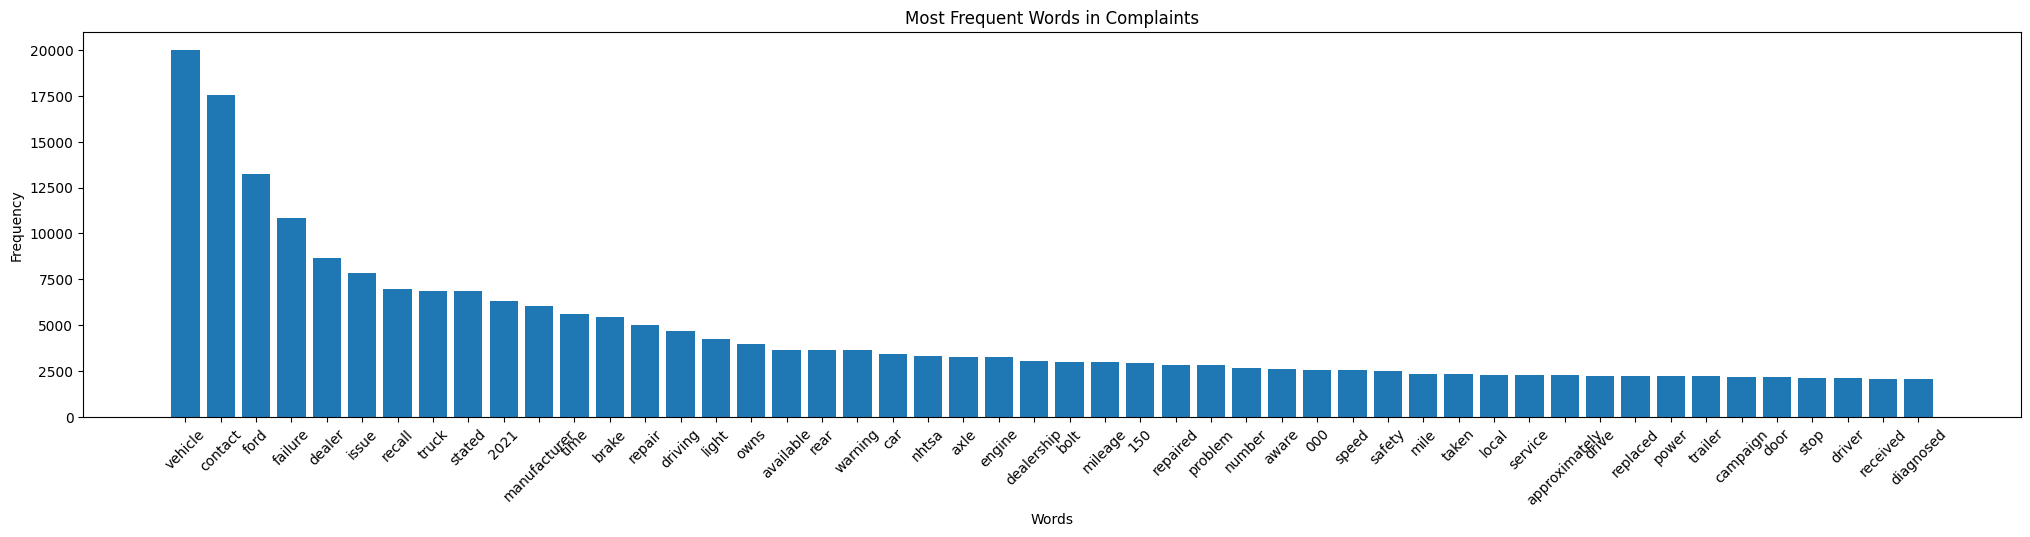

Most Frequent Words in Complaints:
vehicle: 19985
contact: 17542
ford: 13213
failure: 10836
dealer: 8658
issue: 7862
recall: 6952
truck: 6876
stated: 6866
2021: 6318
manufacturer: 6035
time: 5610
brake: 5460
repair: 5008
driving: 4696
light: 4234
owns: 3994
available: 3653
rear: 3634
car: 3416
nhtsa: 3330
axle: 3265
engine: 3249
dealership: 3020
bolt: 2975
mileage: 2974
150: 2947
repaired: 2829
problem: 2822
number: 2674
aware: 2623
000: 2543
speed: 2529
safety: 2496
mile: 2318
taken: 2315
local: 2284
service: 2267
approximately: 2258
drive: 2216
replaced: 2211
power: 2204
trailer: 2202
campaign: 2198
door: 2150
stop: 2131
driver: 2129
received: 2067
diagnosed: 2049


In [15]:
texts = df_final['processed_summary'].dropna()  

# Analyzing the most frequent words using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # Remove common stopwords and limit to top 50 words
word_counts = vectorizer.fit_transform(texts)  # Transform the text into a matrix of word counts

# Get the most frequent words
words_freq = dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1))
sorted_words_freq = sorted(words_freq.items(), key=lambda x: x[1], reverse=True)  # Sort words by frequency

# Visualize the most frequent words with a bar chart
plt.figure(figsize=(25, 5))  
plt.bar(*zip(*sorted_words_freq))  
plt.xticks(rotation=45)  
plt.title('Most Frequent Words in Complaints')  
plt.xlabel('Words')  
plt.ylabel('Frequency')  
plt.show()  

# Display the most frequent words in the console
print("Most Frequent Words in Complaints:")
for word, freq in sorted_words_freq:
    print(f"{word}: {freq}")


The word "recall" appears 6,635 times, suggesting that many complaints are related to safety issues that could result in a recall.
Terms such as "failure" (10,606), "issue" (6,746), "problem" (2,573), and "safety" (2,496) also indicate a strong emphasis on critical technical issues.

Terms like "nhtsa" (3,330) indicate that consumers frequently mention the National Highway Traffic Safety Administration (NHTSA) in their complaints, possibly to report serious failures.

In [19]:
df_final.columns

Index(['Year', 'Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'components', 'summary',
       'daysBetween', 'components_list', 'processed_summary',
       'sumarry_embedding', 'model_embedding', 'word_count', 'char_count',
       'sentiment', 'general_category', 'category_binary', 'is_recall'],
      dtype='object')

In [31]:
df_final.dtypes

Year                           int64
Model                         object
crash                          int64
fire                           int64
numberOfInjuries               int64
numberOfDeaths                 int64
dateOfIncident        datetime64[ns]
dateComplaintFiled    datetime64[ns]
components                    object
summary                       object
daysBetween                    int64
components_list               object
processed_summary             object
sumarry_embedding             object
model_embedding               object
word_count                     int64
char_count                     int64
sentiment                    float64
general_category              object
category_binary               object
is_recall                      int64
dtype: object

In [ ]:
rint(a)

In [27]:
# Converta as colunas de listas em strings antes de salvar
df_final['sumarry_embedding'] = df_final['sumarry_embedding'].apply(lambda x: str(x))
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: str(x))

KeyboardInterrupt: 

In [40]:
import json 
# Converta as colunas de embeddings (ndarray) para listas antes de salvar como JSON
df_final['sumarry_embedding'] = df_final['sumarry_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['model_embedding'] = df_final['model_embedding'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)
df_final['category_binary'] = df_final['category_binary'].apply(lambda x: json.dumps(x.tolist()) if isinstance(x, np.ndarray) else x)

In [38]:
df_final['sumarry_embedding'] = df_final['sumarry_embedding'].tolist()

In [41]:
df_final

,Year,Model,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,components,summary,...,components_list,processed_summary,sumarry_embedding,model_embedding,word_count,char_count,sentiment,general_category,category_binary,is_recall
0,2021,F-350 REGULAR CAB,0,0,0,0,2024-12-29,2025-01-19,"POWER TRAIN,ELECTRICAL SYSTEM",Ford knew there was an issue back in 2021 as t...,...,"[POWER TRAIN, ELECTRICAL SYSTEM]",ford knew issue back 2021 filed agency yet wai...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.040037598460912704, -0.27900347113609314, -...",80,518,0.091667,"[Engine and Performance, Electrical System]","[1, 1, 0, 0, 0]",0
1,2021,F-350 REGULAR CAB,0,0,0,0,2025-01-15,2025-01-15,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,...,"[FUEL SYSTEM, DIESEL]",contact owns 2021 ford f 350 contact received ...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.040037598460912704, -0.27900347113609314, -...",106,780,0.023333,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]",1
2,2021,F-350 REGULAR CAB,0,0,0,0,2024-02-14,2025-01-14,"SUSPENSION,FUEL SYSTEM, DIESEL,SERVICE BRAKES",The contact owns a 2021 Ford F-350. The contac...,...,"[SUSPENSION, FUEL SYSTEM, DIESEL, SERVICE BRA...",contact owns 2021 ford f 350 contact received ...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.040037598460912704, -0.27900347113609314, -...",146,1114,-0.004067,"[Engine and Performance, Safety and Brakes, St...","[0, 1, 1, 1, 1]",1
3,2021,F-350 REGULAR CAB,0,0,0,0,2024-11-26,2025-01-09,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,...,"[FUEL SYSTEM, DIESEL]",contact owns 2021 ford f 350 contact received ...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.040037598460912704, -0.27900347113609314, -...",98,726,-0.041538,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]",1
4,2021,F-350 REGULAR CAB,0,0,0,0,2024-12-30,2025-01-03,STEERING,Death wobble: while driving approximately 60 M...,...,[STEERING],death wobble driving approximately 60 mph brid...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.040037598460912704, -0.27900347113609314, -...",28,212,-0.250000,[Structure and Control],"[0, 0, 0, 0, 1]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13409,2021,EXPLORER HEV,0,0,0,0,2023-08-23,2023-11-24,ELECTRICAL SYSTEM,The contact owns a 2021 Ford Explorer Hybrid. ...,...,[ELECTRICAL SYSTEM],contact owns 2021 ford explorer hybrid contact...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.13206347823143005, 0.12773659825325012, 0.1...",66,501,0.033000,[Electrical System],"[1, 0, 0, 0, 0]",1
13410,2021,EXPLORER HEV,0,0,0,0,2023-01-12,2023-01-12,"POWER TRAIN,STRUCTURE",The contact owns a 2021 Ford Explorer Hybrid. ...,...,"[POWER TRAIN, STRUCTURE]",contact owns 2021 ford explorer hybrid contact...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.13206347823143005, 0.12773659825325012, 0.1...",66,493,-0.141667,"[Engine and Performance, Structure and Control]","[0, 1, 0, 0, 1]",0
13411,2021,EXPLORER HEV,0,0,0,0,2023-08-23,2023-11-24,ELECTRICAL SYSTEM,The contact owns a 2021 Ford Explorer Hybrid. ...,...,[ELECTRICAL SYSTEM],contact owns 2021 ford explorer hybrid contact...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.13206347823143005, 0.12773659825325012, 0.1...",66,501,0.033000,[Electrical System],"[1, 0, 0, 0, 0]",1
13412,2021,EXPLORER HEV,0,0,0,0,2023-01-12,2023-01-12,"POWER TRAIN,STRUCTURE",The contact owns a 2021 Ford Explorer Hybrid. ...,...,"[POWER TRAIN, STRUCTURE]",contact owns 2021 ford explorer hybrid contact...,<bound method IndexOpsMixin.tolist of 0 ...,"[0.13206347823143005, 0.12773659825325012, 0.1...",66,493,-0.141667,"[Engine and Performance, Structure and Control]","[0, 1, 0, 0, 1]",0


In [29]:
df_final.head(3)

,Year,Model,crash,fire,numberOfInjuries,numberOfDeaths,dateOfIncident,dateComplaintFiled,components,summary,...,components_list,processed_summary,sumarry_embedding,model_embedding,word_count,char_count,sentiment,general_category,category_binary,is_recall
0,2021,F-350 REGULAR CAB,0,0,0,0,2024-12-29,2025-01-19,"POWER TRAIN,ELECTRICAL SYSTEM",Ford knew there was an issue back in 2021 as t...,...,"[POWER TRAIN, ELECTRICAL SYSTEM]",ford knew issue back 2021 filed agency yet wai...,[-1.25882432e-01 9.36835334e-02 5.17301857e-...,"[0.040037598460912704, -0.27900347113609314, -...",80,518,0.091667,"[Engine and Performance, Electrical System]","[1, 1, 0, 0, 0]",0
1,2021,F-350 REGULAR CAB,0,0,0,0,2025-01-15,2025-01-15,"FUEL SYSTEM, DIESEL",The contact owns a 2021 Ford F-350. The contac...,...,"[FUEL SYSTEM, DIESEL]",contact owns 2021 ford f 350 contact received ...,[-4.83598977e-01 -1.92022324e-01 2.60853291e-...,"[0.040037598460912704, -0.27900347113609314, -...",106,780,0.023333,"[Engine and Performance, Other Problems]","[0, 1, 1, 0, 0]",1
2,2021,F-350 REGULAR CAB,0,0,0,0,2024-02-14,2025-01-14,"SUSPENSION,FUEL SYSTEM, DIESEL,SERVICE BRAKES",The contact owns a 2021 Ford F-350. The contac...,...,"[SUSPENSION, FUEL SYSTEM, DIESEL, SERVICE BRA...",contact owns 2021 ford f 350 contact received ...,[-5.99698186e-01 -1.06159344e-01 2.29459375e-...,"[0.040037598460912704, -0.27900347113609314, -...",146,1114,-0.004067,"[Engine and Performance, Safety and Brakes, St...","[0, 1, 1, 1, 1]",1


In [36]:
df_final[['processed_summary', 'sumarry_embedding', 'model_embedding', 'word_count', 'char_count',
          'sentiment', 'is_recall', 'category_binary']].to_csv('df_final_model.csv',index=False)

In [34]:
# Salvar em formato JSON
df_final[['processed_summary', 'sumarry_embedding', 'model_embedding', 'word_count', 'char_count',
          'sentiment', 'is_recall', 'category_binary']].to_json('df_final_model.json', orient='records')


In [116]:
df_final[['Year','Model', 'crash', 'fire', 'numberOfInjuries', 'numberOfDeaths',
       'dateOfIncident', 'dateComplaintFiled', 'summary',
       'daysBetween', 'components_list','sentiment',
       'general_category', 'is_recall', 'word_count',
       'char_count']].to_csv('df_final_chart.csv',index=False)